# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
import abc
import cv2
import matplotlib.pyplot as plt
import pathlib
import time
from sys import getsizeof
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
from tensorflow import random
random.set_seed(30)

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!unzip "/content/gdrive/MyDrive/GestureDetection/Project_data.zip" -d "/content"

Archive:  /content/gdrive/MyDrive/GestureDetection/Project_data.zip
replace /content/Project_data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
project_folder='/content/Project_data'

### Plotting

In [6]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
train_doc = np.random.permutation(open(pathlib.Path(project_folder+'/train.csv')).readlines())
val_doc = np.random.permutation(open(pathlib.Path(project_folder+'/val.csv')).readlines())


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(pathlib.Path(project_folder + '/' + 'train.csv')).readlines())
        self.val_doc = np.random.permutation(open(pathlib.Path(project_folder + '/' + 'val.csv')).readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising the image properties
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    def train_model(self, model, augment_data=False):
        print("train model")
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    def generator(self,source_path, folder_list, augment=False):
        start = time.time()
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels

    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height, self.image_width,self.channels))

        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                image_resized= cv2.resize(image, (self.image_height, self.image_width), interpolation = cv2.INTER_AREA)

                #normalizing the images
                batch_data[folder, idx, :, :, 0] = (image_resized[:,:,0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:,:,1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    # cropping the images to have the targeted gestures and remove the noise from the images.

                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized = cv2.resize(cropped, (self.image_height, self.image_width), interpolation = cv2. INTER_AREA)

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data, batch_data_aug])
            batch_labels=np.concatenate([batch_labels, batch_labels])
        return(batch_data,batch_labels)




    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
# curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = 10# choose the number of epochs
# print ('# epochs =', num_epochs)

NameError: name 'train_doc' is not defined

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout



### Sample Model

In [12]:
class ModelConv3D(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d1 = ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 160, 160, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4

### Sample Cropping

In [14]:
test_generator = ModelConv3D()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

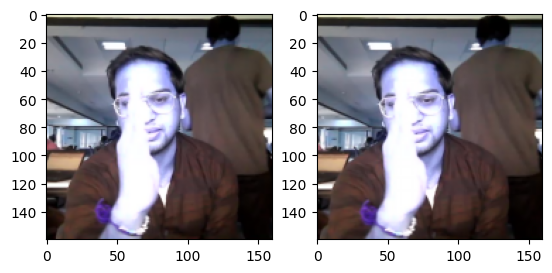

In [15]:
g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

### Experimenting with Image resolution, number of frames to use and batch_size

In [16]:
conv_3d1.train_model(conv_3d1_model)

train model
133/133 [==============================] - ETA: 0s - loss: 1.7969 - categorical_accuracy: 0.3318
Epoch 1: val_loss improved from inf to 20.66554, saving model to model_init_2024-03-0411_32_21.745518/model-00001-1.79690-0.33183-20.66554-0.21000.h5
133/133 [==============================] - 77s 522ms/step - loss: 1.7969 - categorical_accuracy: 0.3318 - val_loss: 20.6655 - val_categorical_accuracy: 0.2100 - lr: 0.0010


### It is taking too much time to process

#### So lets trade-off between these parameters

#### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [17]:
conv_3d1 = ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)

conv_3d1_model= conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1211461
train model
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.4828 - categorical_accuracy: 0.4510
Epoch 1: val_loss improved from inf to 1.87549, saving model to model_init_2024-03-0411_33_39.477012/model-00001-1.48281-0.45098-1.87549-0.26000.h5
23/23 [==============================] - 33s 1s/step - loss: 1.4828 - categorical_accuracy: 0.4510 - val_loss: 1.8755 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/2
22/23 [===========================>..] - ETA: 0s - loss: 1.0863 - categorical_accuracy: 0.5712
Epoch 2: val_loss did not improve from 1.87549
23/23 [==============================] - 27s 1s/step - loss: 1.0983 - categorical_accuracy: 0.5686 - val_loss: 3.2618 - val_categorical_accuracy: 0.2000 - lr: 0.0010


In [18]:
conv_3d1 = ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 3570757
train model
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.4383 - categorical_accuracy: 0.4495
Epoch 1: val_loss improved from inf to 4.31073, saving model to model_init_2024-03-0411_34_40.608564/model-00001-1.43835-0.44947-4.31073-0.21000.h5
34/34 [==============================] - 60s 2s/step - loss: 1.4383 - categorical_accuracy: 0.4495 - val_loss: 4.3107 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 0.9104 - categorical_accuracy: 0.6124
Epoch 2: val_loss did not improve from 4.31073
34/34 [==============================] - 52s 2s/step - loss: 0.9104 - categorical_accuracy: 0.6124 - val_loss: 10.2145 - val_categorical_accuracy: 0.2000 - lr: 0.0010


In [19]:
conv_3d1=ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 9862213
train model
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6302 - categorical_accuracy: 0.3982
Epoch 1: val_loss improved from inf to 6.41537, saving model to model_init_2024-03-0411_36_34.369756/model-00001-1.63022-0.39819-6.41537-0.21000.h5
45/45 [==============================] - 72s 1s/step - loss: 1.6302 - categorical_accuracy: 0.3982 - val_loss: 6.4154 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.2129 - categorical_accuracy: 0.5505
Epoch 2: val_loss did not improve from 6.41537
45/45 [==============================] - 65s 1s/step - loss: 1.2129 - categorical_accuracy: 0.5505 - val_loss: 14.6544 - val_categorical_accuracy: 0.2500 - lr: 0.0010


In [20]:
conv_3d1=ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 6585413
train model
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.5530 - categorical_accuracy: 0.4223
Epoch 1: val_loss improved from inf to 4.60098, saving model to model_init_2024-03-0411_38_53.245016/model-00001-1.55300-0.42232-4.60098-0.21000.h5
23/23 [==============================] - 43s 2s/step - loss: 1.5530 - categorical_accuracy: 0.4223 - val_loss: 4.6010 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
22/23 [===========================>..] - ETA: 1s - loss: 1.0155 - categorical_accuracy: 0.6076
Epoch 2: val_loss did not improve from 4.60098
23/23 [==============================] - 34s 2s/step - loss: 1.0178 - categorical_accuracy: 0.6078 - val_loss: 12.4316 - val_categorical_accuracy: 0.2500 - lr: 0.0010


* As we see from the above experiments "image resolution" and number of frames in sequence have more impact on training time than batch_size
* We can consider the Batch Size around 15-40
* We will change the resoulution 160x160, 120x120 according the model performance

### Model 1

### Base Model - Batch Size = 40 and No. of Epochs = 15

In [21]:
class ModelConv3D1(ModelBuilder):

    def define_model(self, filtersize = (3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40, num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_15 (Activation)  (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_25 (Ba  (None, 20, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 10, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_16 (Conv3D)          (None, 10, 80, 80, 32)   

In [23]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
train model
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5214 - categorical_accuracy: 0.4133
Epoch 1: val_loss improved from inf to 2.48508, saving model to model_init_2024-03-0411_40_12.023492/model-00001-1.52137-0.41327-2.48508-0.25000.h5
17/17 [==============================] - 60s 3s/step - loss: 1.5214 - categorical_accuracy: 0.4133 - val_loss: 2.4851 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0783 - categorical_accuracy: 0.6018
Epoch 2: val_loss improved from 2.48508 to 1.83248, saving model to model_init_2024-03-0411_40_12.023492/model-00002-1.07825-0.60181-1.83248-0.17000.h5
17/17 [==============================] - 41s 3s/step - loss: 1.0783 - categorical_accuracy: 0.6018 - val_loss: 1.8325 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8217 - categorical_accuracy: 0.6863
Epoch 3: val_los

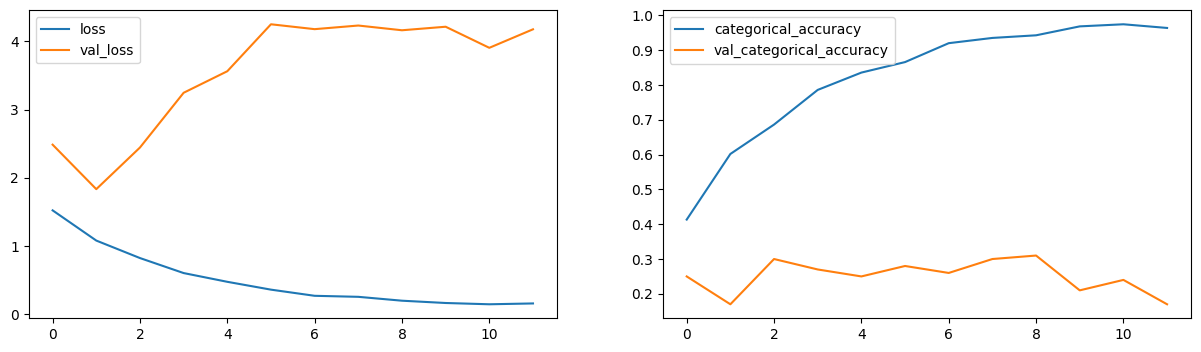

In [24]:
plot(history_model1)

#### Model is clearly underfitting. :(

### Model 2

##### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [26]:
conv_3d2 = ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model= conv_3d2.define_model(dense_neurons = 256, dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_23 (Conv3D)          (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_23 (Activation)  (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_37 (Ba  (None, 20, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_23 (MaxPooli  (None, 10, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_24 (Conv3D)          (None, 10, 80, 80, 32)   

In [27]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model, augment_data=True)

Total Params: 3638981
train model
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8778 - categorical_accuracy: 0.3989
Epoch 1: val_loss improved from inf to 2.33595, saving model to model_init_2024-03-0411_50_49.929282/model-00001-1.87782-0.39894-2.33595-0.29000.h5
34/34 [==============================] - 92s 3s/step - loss: 1.8778 - categorical_accuracy: 0.3989 - val_loss: 2.3360 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2649 - categorical_accuracy: 0.5535
Epoch 2: val_loss did not improve from 2.33595
34/34 [==============================] - 82s 2s/step - loss: 1.2649 - categorical_accuracy: 0.5535 - val_loss: 4.4968 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1018 - categorical_accuracy: 0.6176
Epoch 3: val_loss did not improve from 2.33595
34/34 [==============================] - 82s 2s/step - loss: 1.1018 - cate

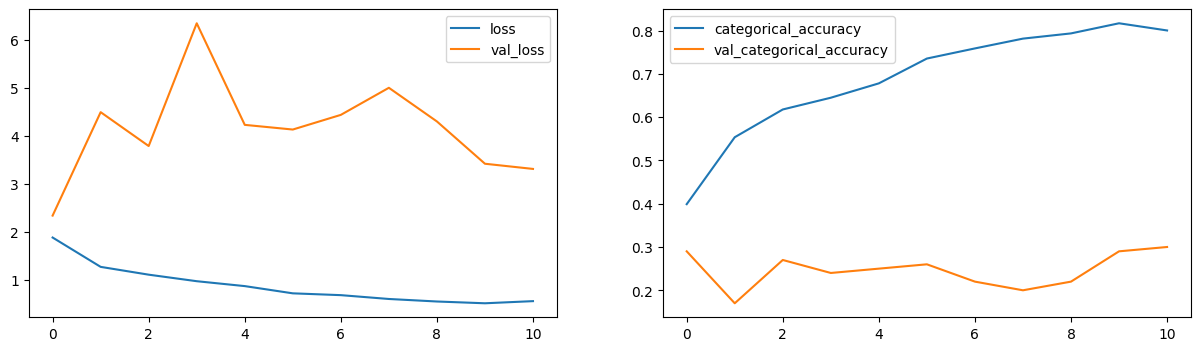

In [28]:
plot(history_model2)

### We can see val_loss did not improve from 2.08951 so earlystopping stops the epoch automatically!!
* Last Epoch stop on 11/25!! good job earlystopping ;)
* Best weights save automatically. The validation accuracy of 27% and training accuracy of 77%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002

### Model 3

##### Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 25

In [29]:
class ModelConv3D3(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 16, 120, 120, 16   400       
                             )                                   
                                                                 
 activation_27 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_43 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_27 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_28 (Conv3D)          (None, 8, 60, 60, 32)    

In [31]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model, augment_data=True)

Total Params: 1762613
train model
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1107 - categorical_accuracy: 0.3333
Epoch 1: val_loss improved from inf to 1.71586, saving model to model_init_2024-03-0412_06_27.292504/model-00001-2.11068-0.33333-1.71586-0.21000.h5
23/23 [==============================] - 61s 2s/step - loss: 2.1107 - categorical_accuracy: 0.3333 - val_loss: 1.7159 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
22/23 [===========================>..] - ETA: 2s - loss: 1.4952 - categorical_accuracy: 0.4811
Epoch 2: val_loss did not improve from 1.71586
23/23 [==============================] - 52s 2s/step - loss: 1.4966 - categorical_accuracy: 0.4811 - val_loss: 2.2536 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/25
22/23 [===========================>..] - ETA: 2s - loss: 1.2447 - categorical_accuracy: 0.5492
Epoch 3: val_loss did not improve from 1.71586
23/23 [==============================] - 53s 2s/step - loss: 1.251

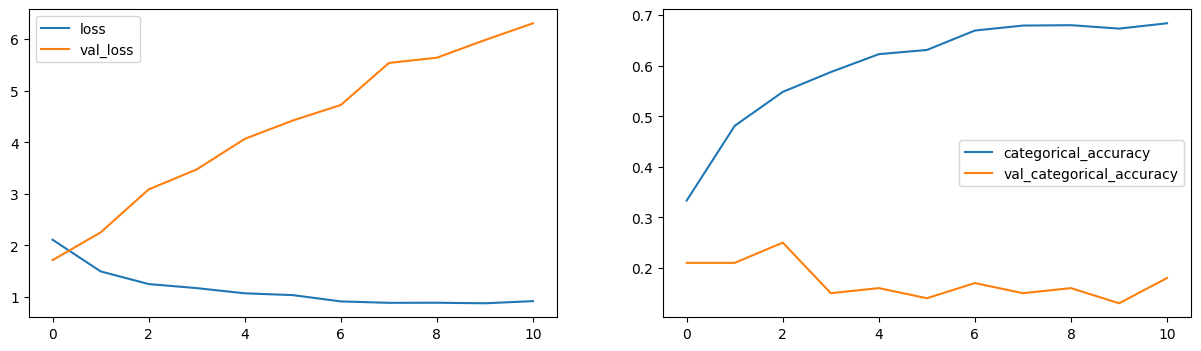

In [32]:
plot(history_model3)

##### Model has a best validation accuracy of 20% and training accuracy of 70% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

### Model 4 -

##### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [35]:
class ModelConv3D4(ModelBuilder):

    def define_model(self,filtersize=(3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
conv_3d4 = ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_39 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_59 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 16 

In [37]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
train model
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9633 - categorical_accuracy: 0.3680
Epoch 1: val_loss improved from inf to 1.52297, saving model to model_init_2024-03-0412_18_28.664612/model-00001-1.96326-0.36802-1.52297-0.36000.h5
34/34 [==============================] - 82s 2s/step - loss: 1.9633 - categorical_accuracy: 0.3680 - val_loss: 1.5230 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6789 - categorical_accuracy: 0.4412
Epoch 2: val_loss did not improve from 1.52297
34/34 [==============================] - 55s 2s/step - loss: 1.6789 - categorical_accuracy: 0.4412 - val_loss: 3.3667 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4660 - categorical_accuracy: 0.4985
Epoch 3: val_loss did not improve from 1.52297
34/34 [==============================] - 54s 2s/step - loss: 1.4660 - cate

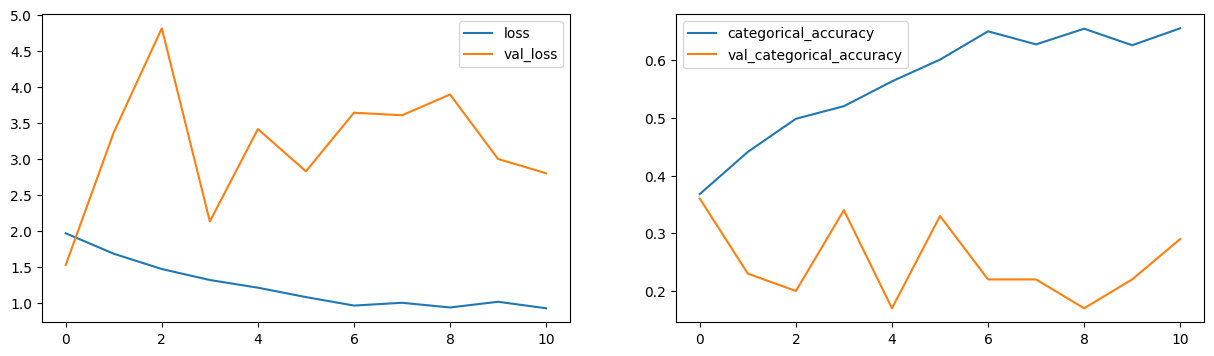

In [38]:
plot(history_model4)

#### With more layers we dont see much performance improvement. We get a best validation accuracy of 36% . Let's try adding dropouts at the convolution layers

### Model 5
#### Adding dropout at convolution layers

In [39]:
class ModelConv3D5(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [40]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_47 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_47 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_69 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16 

In [41]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
train model
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7592 - categorical_accuracy: 0.3959
Epoch 1: val_loss improved from inf to 2.03276, saving model to model_init_2024-03-0412_32_50.809697/model-00001-1.75917-0.39593-2.03276-0.21000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.7592 - categorical_accuracy: 0.3959 - val_loss: 2.0328 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3052 - categorical_accuracy: 0.5279
Epoch 2: val_loss improved from 2.03276 to 1.91120, saving model to model_init_2024-03-0412_32_50.809697/model-00002-1.30522-0.52790-1.91120-0.23000.h5
34/34 [==============================] - 55s 2s/step - loss: 1.3052 - categorical_accuracy: 0.5279 - val_loss: 1.9112 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.1147 - categorical_accuracy: 0.5920
Epoch 3: val_los

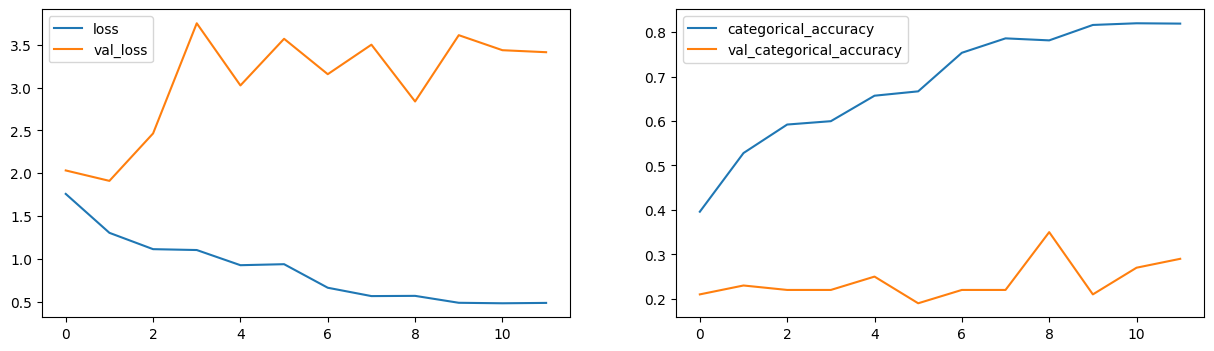

In [42]:
plot(history_model5)

#### Ohh! underfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.

**All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance**

## Model 6
### Reducing the number of parameters

In [43]:
class ModelConv3D6(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_55 (Conv3D)          (None, 16, 100, 100, 16   1312      
                             )                                   
                                                                 
 activation_55 (Activation)  (None, 16, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization_79 (Ba  (None, 16, 100, 100, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_43 (MaxPooli  (None, 8, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_56 (Conv3D)          (None, 8, 50, 50, 32)   

In [45]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
train model
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8315 - categorical_accuracy: 0.3650
Epoch 1: val_loss improved from inf to 1.82616, saving model to model_init_2024-03-0412_45_25.035492/model-00001-1.83152-0.36501-1.82616-0.16000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.8315 - categorical_accuracy: 0.3650 - val_loss: 1.8262 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
33/34 [============================>.] - ETA: 1s - loss: 1.1872 - categorical_accuracy: 0.5598
Epoch 2: val_loss did not improve from 1.82616
34/34 [==============================] - 52s 2s/step - loss: 1.1863 - categorical_accuracy: 0.5596 - val_loss: 2.5258 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0104 - categorical_accuracy: 0.6176
Epoch 3: val_loss did not improve from 1.82616
34/34 [==============================] - 51s 2s/step - loss: 1.0104

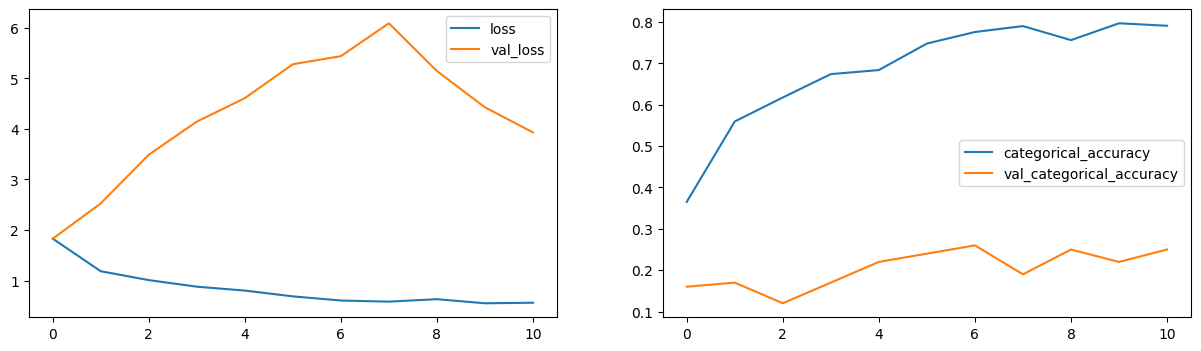

In [46]:
plot(history_model6)

For the above low memory foot print model, we get the best validation accuracy of 25%

## Model 7 - Reducing the number of parameters again

In [47]:
class ModelConv3D7(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [48]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_59 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_59 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_85 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_47 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_60 (Conv3D)          (None, 8, 60, 60, 32)   

In [49]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
train model
Epoch 1/25
33/34 [============================>.] - ETA: 1s - loss: 1.8135 - categorical_accuracy: 0.3591
Epoch 1: val_loss improved from inf to 1.88136, saving model to model_init_2024-03-0412_55_50.277232/model-00001-1.80952-0.35973-1.88136-0.16000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.8095 - categorical_accuracy: 0.3597 - val_loss: 1.8814 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.1855 - categorical_accuracy: 0.5402
Epoch 2: val_loss did not improve from 1.88136
34/34 [==============================] - 53s 2s/step - loss: 1.1873 - categorical_accuracy: 0.5407 - val_loss: 3.1608 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9897 - categorical_accuracy: 0.6071
Epoch 3: val_loss did not improve from 1.88136
34/34 [==============================] - 53s 2s/step - loss: 0.9897

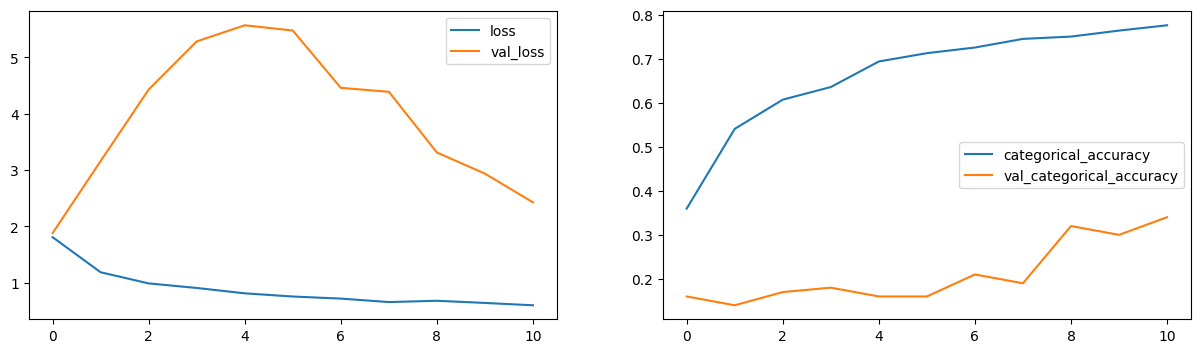

In [50]:
plot(history_model7)

For the above low memory foot print model the best validation accuracy of 34%

## Model 8 - CNN- LSTM Model

In [51]:
class RNNCNN1(ModelBuilder):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
        return model

In [52]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 18, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 18, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 18, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 18, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 18, 60, 60, 32)  

In [53]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
train model
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3587 - accuracy: 0.4140 - categorical_accuracy: 0.4140
Epoch 1: val_loss improved from inf to 1.72138, saving model to model_init_2024-03-0413_06_20.440477/model-00001-1.35868-0.41403-1.72138-0.21000.h5
34/34 [==============================] - 76s 2s/step - loss: 1.3587 - accuracy: 0.4140 - categorical_accuracy: 0.4140 - val_loss: 1.7214 - val_accuracy: 0.2100 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1484 - accuracy: 0.5339 - categorical_accuracy: 0.5339
Epoch 2: val_loss did not improve from 1.72138
34/34 [==============================] - 61s 2s/step - loss: 1.1484 - accuracy: 0.5339 - categorical_accuracy: 0.5339 - val_loss: 1.8390 - val_accuracy: 0.1300 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0392 - accuracy: 0.5739 - categoric

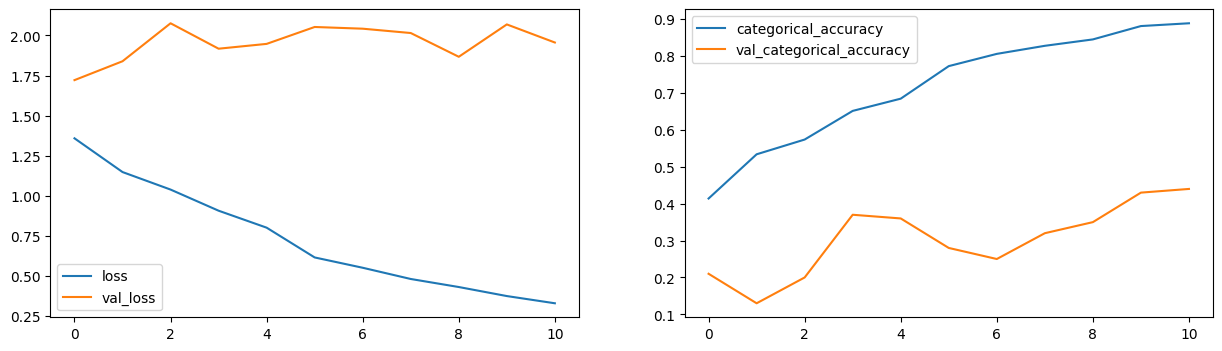

In [54]:
plot(history_model8)

### For CNN - LSTM model we get a best validation accuracy of 44%
As we see more cases of underfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [55]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs


    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized= cv2.resize(image,(self.image_height,self.image_width), interpolation = cv2.INTER_AREA)


                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized= cv2.resize(cropped,(self.image_height,self.image_width), interpolation = cv2.INTER_AREA)

                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

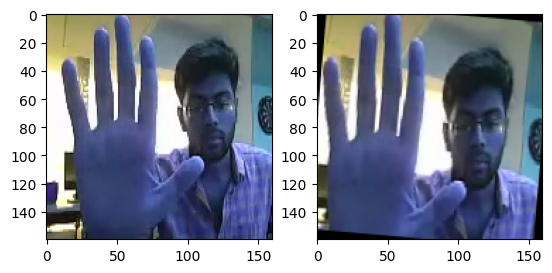

In [56]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])
axes[1].imshow(batch_data[3,29,:,:,:])

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [57]:
class ModelConv3D9(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [58]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_63 (Conv3D)          (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_63 (Activation)  (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_96 (Ba  (None, 20, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_51 (MaxPooli  (None, 10, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_64 (Conv3D)          (None, 10, 80, 80, 32)  

In [59]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.9819 - categorical_accuracy: 0.3763
Epoch 1: saving model to model_init_2024-03-0413_20_44.967156/model-00001-1.98191-0.37632-2.46142-0.16000.h5
34/34 [==============================] - 96s 3s/step - loss: 1.9819 - categorical_accuracy: 0.3763 - val_loss: 2.4614 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4943 - categorical_accuracy: 0.4744
Epoch 2: saving model to model_init_2024-03-0413_20_44.967156/model-00002-1.49426-0.47436-3.66036-0.21000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.4943 - categorical_accuracy: 0.4744 - val_loss: 3.6604 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3776 - categorical_accuracy: 0.5302
Epoch 3: saving model to model_init_2024-03-0413_20_44.967156/model-00003-1.37762-0.53017-4.92701-0.23

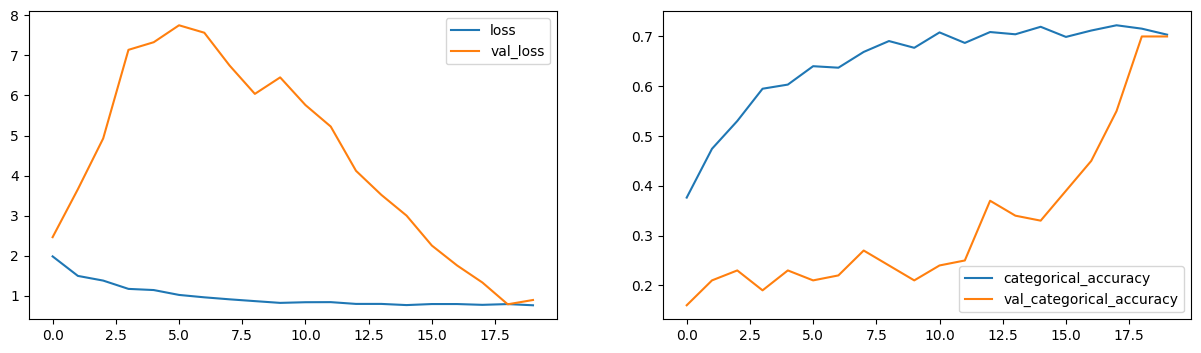

In [60]:
plot(history_model9)

For CNN  model with augmentatio we get a best train accuracy of 70% and validation accuracy of 70%

## Model 10 with Augmentation
### (2,2,2) Filter & 120x120 Image resolution - similar to Model 3

In [61]:
class ModelConv3D10(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [62]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_67 (Conv3D)          (None, 16, 120, 120, 16   400       
                             )                                   
                                                                 
 activation_67 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_102 (B  (None, 16, 120, 120, 16   64        
 atchNormalization)          )                                   
                                                                 
 max_pooling3d_55 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_68 (Conv3D)          (None, 8, 60, 60, 32)   

In [63]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
22/23 [===========================>..] - ETA: 2s - loss: 2.0683 - categorical_accuracy: 0.3402
Epoch 1: saving model to model_init_2024-03-0413_50_30.808056/model-00001-2.07008-0.33937-1.80891-0.16000.h5
23/23 [==============================] - 62s 3s/step - loss: 2.0701 - categorical_accuracy: 0.3394 - val_loss: 1.8089 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
22/23 [===========================>..] - ETA: 2s - loss: 1.4568 - categorical_accuracy: 0.4909
Epoch 2: saving model to model_init_2024-03-0413_50_30.808056/model-00002-1.45725-0.49020-2.74709-0.13000.h5
23/23 [==============================] - 55s 2s/step - loss: 1.4572 - categorical_accuracy: 0.4902 - val_loss: 2.7471 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/25
22/23 [===========================>..] - ETA: 2s - loss: 1.2995 - categorical_accuracy: 0.5455
Epoch 3: saving model to model_init_2024-03-0413_50_30.808056/model-00003-1.29570-0.54676-3.49214-0.15

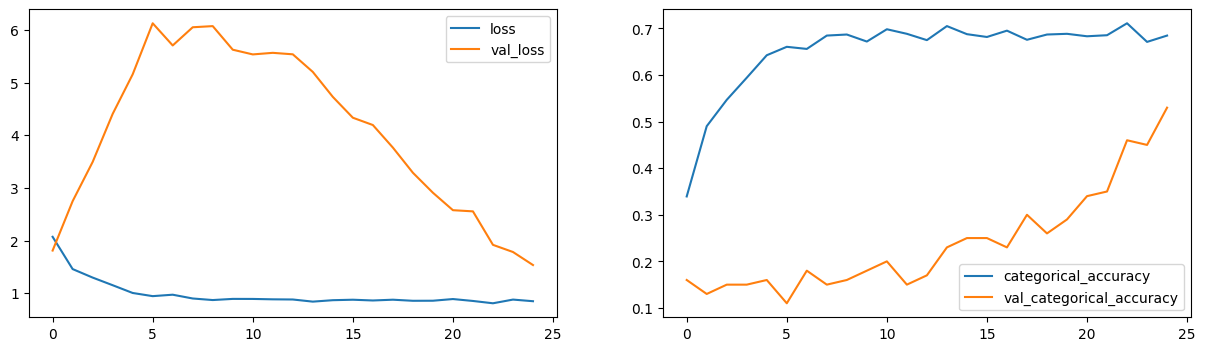

In [64]:
plot(history_model10)

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [65]:
class ModelConv3D11(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [66]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_71 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_71 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_108 (B  (None, 16, 120, 120, 16   64        
 atchNormalization)          )                                   
                                                                 
 conv3d_72 (Conv3D)          (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_72 (Activation)  (None, 16, 120, 120, 16 

In [67]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1433 - categorical_accuracy: 0.3439
Epoch 1: saving model to model_init_2024-03-0414_13_56.096660/model-00001-2.14325-0.34389-2.36858-0.16000.h5
34/34 [==============================] - 65s 2s/step - loss: 2.1433 - categorical_accuracy: 0.3439 - val_loss: 2.3686 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6002 - categorical_accuracy: 0.4691
Epoch 2: saving model to model_init_2024-03-0414_13_56.096660/model-00002-1.60023-0.46908-3.57697-0.19000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.6002 - categorical_accuracy: 0.4691 - val_loss: 3.5770 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4028 - categorical_accuracy: 0.5354
Epoch 3: saving model to model_init_2024-03-0414_13_56.096660/model-00003-1.40279-0.53544-4.00598-0.15

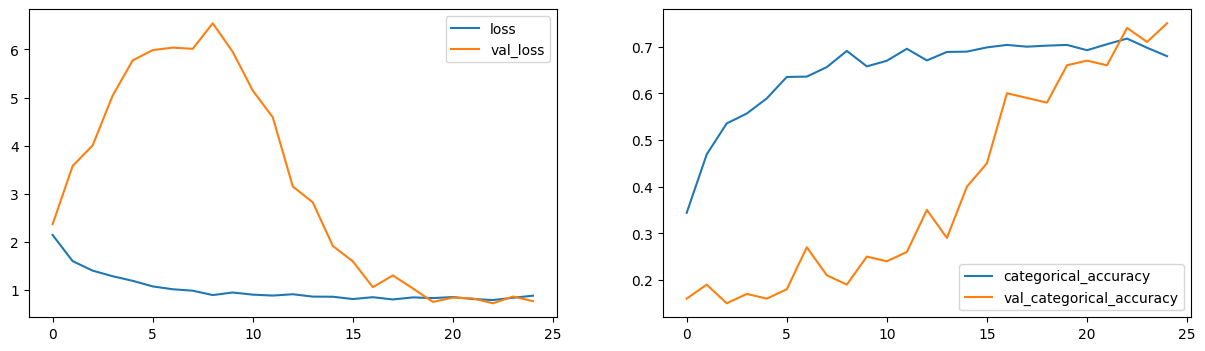

In [68]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [77]:
class ModelConv3D12(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [78]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20, num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_91 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_91 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_134 (B  (None, 16, 120, 120, 16   64        
 atchNormalization)          )                                   
                                                                 
 conv3d_92 (Conv3D)          (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_92 (Activation)  (None, 16, 120, 120, 16 

In [71]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9759 - categorical_accuracy: 0.3190
Epoch 1: saving model to model_init_2024-03-0414_38_05.335590/model-00001-1.97590-0.31900-1.89273-0.21000.h5
34/34 [==============================] - 64s 2s/step - loss: 1.9759 - categorical_accuracy: 0.3190 - val_loss: 1.8927 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5683 - categorical_accuracy: 0.4291
Epoch 2: saving model to model_init_2024-03-0414_38_05.335590/model-00002-1.56827-0.42911-2.13323-0.20000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.5683 - categorical_accuracy: 0.4291 - val_loss: 2.1332 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3917 - categorical_accuracy: 0.5075
Epoch 3: saving model to model_init_2024-03-0414_38_05.335590/model-00003-1.39170-0.50754-2.23851-0.16

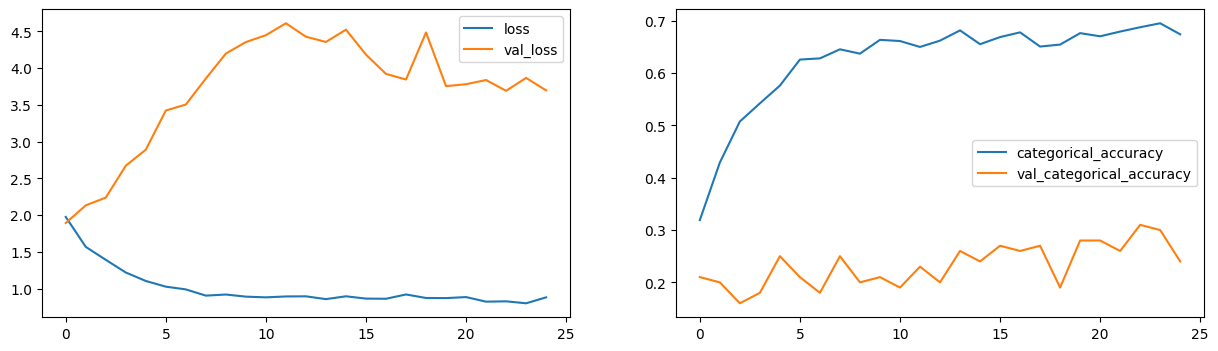

In [72]:
plot(history_model12)

Model is overfitting badly !!

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [73]:
class ModelConv3D13(ModelBuilderMoreAugmentation):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [74]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_87 (Conv3D)          (None, 16, 100, 100, 16   1312      
                             )                                   
                                                                 
 activation_87 (Activation)  (None, 16, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization_128 (B  (None, 16, 100, 100, 16   64        
 atchNormalization)          )                                   
                                                                 
 max_pooling3d_67 (MaxPooli  (None, 8, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_88 (Conv3D)          (None, 8, 50, 50, 32)   

In [75]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8213 - categorical_accuracy: 0.3703
Epoch 1: saving model to model_init_2024-03-0415_02_42.709917/model-00001-1.82128-0.37029-1.68746-0.22000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.8213 - categorical_accuracy: 0.3703 - val_loss: 1.6875 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.2315 - categorical_accuracy: 0.5311
Epoch 2: saving model to model_init_2024-03-0415_02_42.709917/model-00002-1.23245-0.53167-1.93522-0.15000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.2324 - categorical_accuracy: 0.5317 - val_loss: 1.9352 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0395 - categorical_accuracy: 0.6048
Epoch 3: saving model to model_init_2024-03-0415_02_42.709917/model-00003-1.03945-0.60483-2.35454-0.170

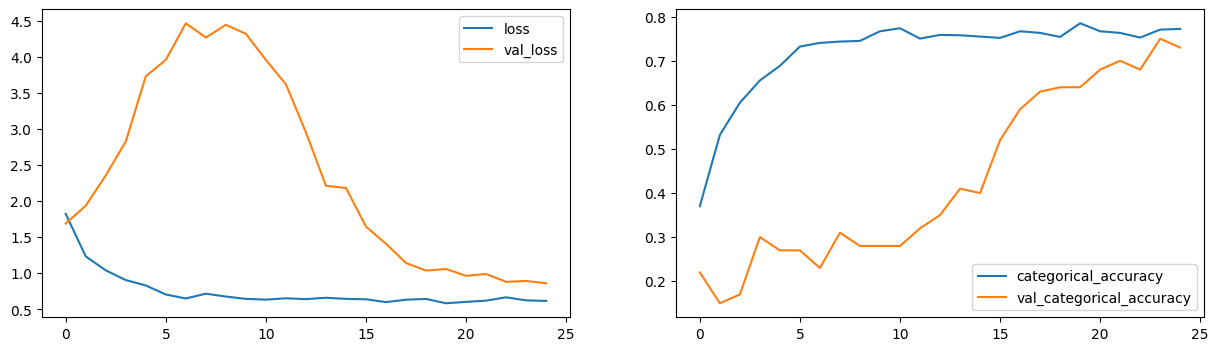

In [76]:
plot(history_model13)

## Model 14 with Augmentation
### Reducing network parameters again - Similar to model 7

In [79]:
class ModelConv3D14(ModelBuilderMoreAugmentation):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [80]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_99 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_99 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_144 (B  (None, 16, 120, 120, 16   64        
 atchNormalization)          )                                   
                                                                 
 max_pooling3d_75 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_100 (Conv3D)         (None, 8, 60, 60, 32)   

In [81]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
33/34 [============================>.] - ETA: 1s - loss: 1.8606 - categorical_accuracy: 0.3311
Epoch 1: saving model to model_init_2024-03-0415_30_22.776368/model-00001-1.85670-0.33107-1.67279-0.21000.h5
34/34 [==============================] - 61s 2s/step - loss: 1.8567 - categorical_accuracy: 0.3311 - val_loss: 1.6728 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.4115 - categorical_accuracy: 0.4629
Epoch 2: saving model to model_init_2024-03-0415_30_22.776368/model-00002-1.41787-0.46078-2.24816-0.23000.h5
34/34 [==============================] - 55s 2s/step - loss: 1.4179 - categorical_accuracy: 0.4608 - val_loss: 2.2482 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/25
33/34 [============================>.] - ETA: 1s - loss: 1.1336 - categorical_accuracy: 0.5644
Epoch 3: saving model to model_init_2024-03-0415_30_22.776368/model-00003-1.13441-0.56410-2.61539-0.290

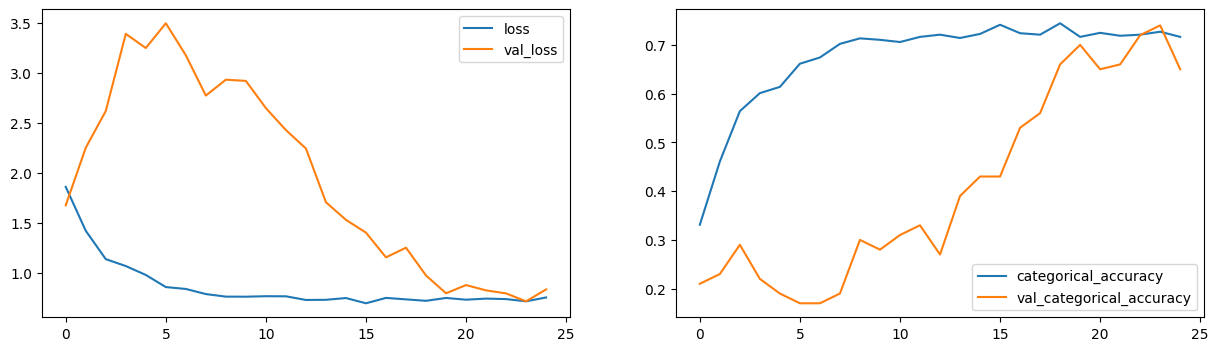

In [82]:
plot(history_model14)

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [83]:
class RNNCNN2(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [84]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeD  (None, 18, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_17 (TimeD  (None, 18, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_18 (TimeD  (None, 18, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 18, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 18, 60, 60, 32)  

In [85]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4393 - categorical_accuracy: 0.3688
Epoch 1: saving model to model_init_2024-03-0415_53_49.776258/model-00001-1.43929-0.36878-1.69720-0.21000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.4393 - categorical_accuracy: 0.3688 - val_loss: 1.6972 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0230 - categorical_accuracy: 0.6086
Epoch 2: saving model to model_init_2024-03-0415_53_49.776258/model-00002-1.02305-0.60860-2.06536-0.22000.h5
34/34 [==============================] - 63s 2s/step - loss: 1.0230 - categorical_accuracy: 0.6086 - val_loss: 2.0654 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7936 - categorical_accuracy: 0.7044
Epoch 3: saving model to model_init_2024-03-0415_53_49.776258/model-00003-0.79364-0.70437-2.11619-0.23

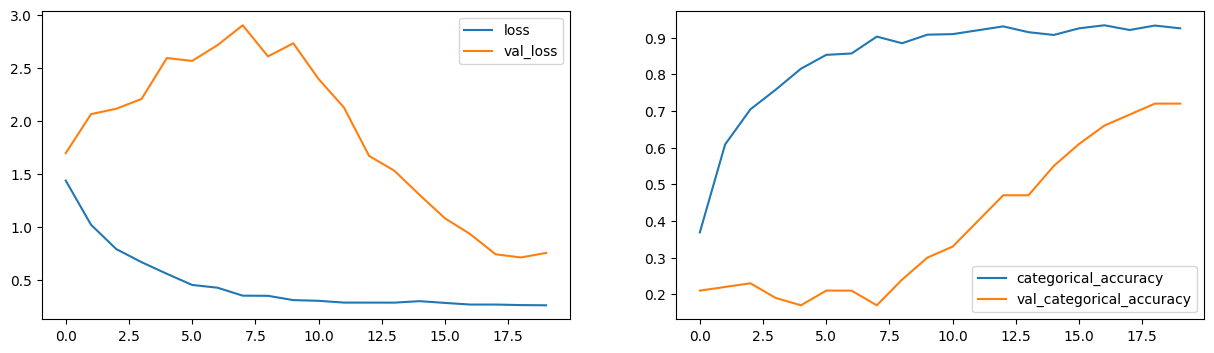

In [86]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

## Model 16 - Let us bring in Transfer Learning !! :)
### (Optional)

In [92]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space
# in the nimblebox.ai platform.

from keras.applications import mobilenet

In [88]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        for layer in model.layers:
            layer.trainable = False


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 1s 0us/step


In [89]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeD  (None, 16, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, 16, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_31 (TimeD  (None, 16, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_32 (TimeD  (None, 16, 1024)          0         
 istributed)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [90]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3899 - categorical_accuracy: 0.4155
Epoch 1: saving model to model_init_2024-03-0416_15_16.193336/model-00001-1.38994-0.41554-0.97027-0.70000.h5
133/133 [==============================] - 62s 427ms/step - loss: 1.3899 - categorical_accuracy: 0.4155 - val_loss: 0.9703 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9432 - categorical_accuracy: 0.6395
Epoch 2: saving model to model_init_2024-03-0416_15_16.193336/model-00002-0.94318-0.63952-0.80322-0.70000.h5
133/133 [==============================] - 53s 401ms/step - loss: 0.9432 - categorical_accuracy: 0.6395 - val_loss: 0.8032 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7009 - categorical_accuracy: 0.7240
Epoch 3: saving model to model_init_2024-03-0416_15_16.193336/model-00003-0.70085-0.72398-0.80

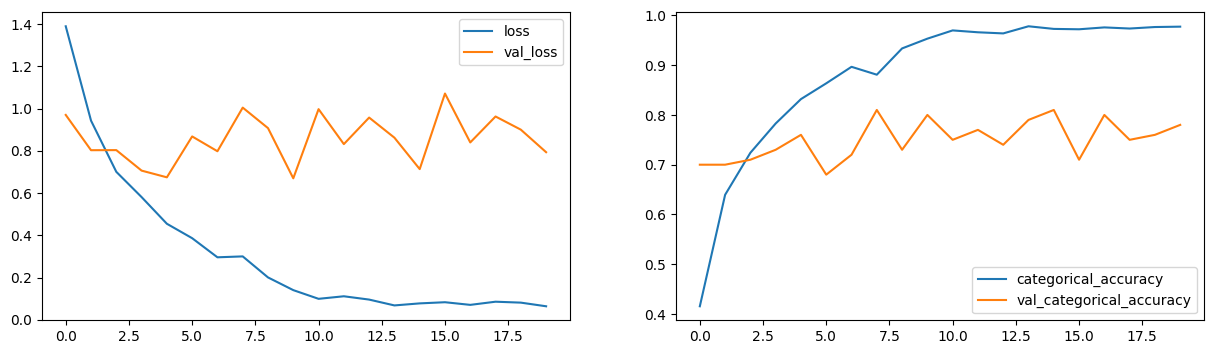

In [91]:
plot(history_model16)

### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 17 - Transfer Learning with GRU and training all weights
### (Optional)

In [93]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):

    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [94]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeD  (None, 16, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_34 (TimeD  (None, 16, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_35 (TimeD  (None, 16, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_36 (TimeD  (None, 16, 1024)          0         
 istributed)                                                     
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [95]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2990 - categorical_accuracy: 0.4796
Epoch 1: saving model to model_init_2024-03-0416_32_51.178403/model-00001-1.29905-0.47964-0.71932-0.74000.h5
133/133 [==============================] - 73s 436ms/step - loss: 1.2990 - categorical_accuracy: 0.4796 - val_loss: 0.7193 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6817 - categorical_accuracy: 0.7308
Epoch 2: saving model to model_init_2024-03-0416_32_51.178403/model-00002-0.68167-0.73077-0.57722-0.80000.h5
133/133 [==============================] - 56s 422ms/step - loss: 0.6817 - categorical_accuracy: 0.7308 - val_loss: 0.5772 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5607 - categorical_accuracy: 0.7783
Epoch 3: saving model to model_init_2024-03-0416_32_51.178403/model-00003-0.56069-0.77828-0.31

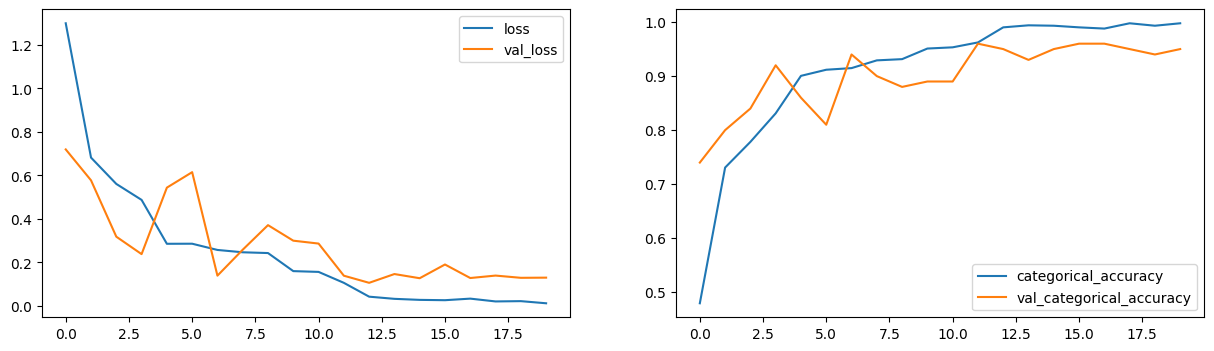

In [96]:
plot(history_model17)

## Awesome results! 99% Training accuracy and 95% validation accuracy :)

# Consolidated Final Models

# After doing all the experiments, we finalized Model 14 - CNN, which performed well.

Reason:

- (Training Accuracy : 75%, Validation Accuracy : 80%)

- Number of Parameters(696645)less according to other models perform
- Model performs well when the number of parameters is reduced


- 

The best weights of CNN-LSTM: model-00025-0.62456-0.75339-0.63580-0.80000.h5 (8.2 MB). we considered this weight for model testing, Let's have look at the performance below

# Loading model and Testing

In [ ]:
import time
from keras.models import load_model
model = load_model('model-00025-0.62456-0.75339-0.63580-0.80000.h5')

OSError: No file or directory found at model_init_2020-06-2522_00_52.036987/model-00020-0.19649-0.93514-0.45695-0.85000.h5

In [ ]:
test_generator=ModelConv3D14()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))